In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from os.path import join
from os import environ

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_new_architecture_test3')

In [3]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'

cantera_species=pd.read_csv(join(home, folder1,folder2,'State_space_cte_pressure_T1418_st-quarter_phi_2.csv'))
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(join(home,folder1,folder2,'Reaction_rates_cte_pressure_T1418_st-quarter_phi_2.csv'))
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    #print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)

(120000, 49)
(120000, 30)
30
(120000, 30)
30


In [6]:
dataset

,t[s],T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,...,CH3OHwshift,C2Hwshift,C2H2wshift,C2H3wshift,C2H4wshift,C2H5wshift,C2H6wshift,HCCOwshift,CH2COwshift,HCCOHwshift
0,0.000008,0.405009,1.042881e-11,8.353616e-10,2.607153e-11,0.956759,1.459889e-11,1.431770e-13,8.863142e-07,6.588270e-10,...,1.612990e-09,3.639861e-28,5.808560e-17,6.301182e-18,1.953841e-08,7.023604e-06,-5.450415e-04,3.064422e-27,2.044251e-27,1.240434e-28
1,0.000017,0.405009,4.062645e-11,1.604340e-09,1.000191e-10,0.956759,5.673373e-11,1.055671e-12,1.772861e-06,2.633485e-09,...,3.494488e-09,1.920113e-27,1.311714e-16,1.864556e-17,2.947984e-08,7.109492e-06,-5.451426e-04,2.172955e-26,1.401526e-26,9.017864e-28
2,0.000025,0.405009,8.906323e-11,2.312391e-09,2.159000e-10,0.956759,1.240263e-10,3.429429e-12,2.659651e-06,5.923432e-09,...,5.983634e-09,6.016944e-27,2.341017e-16,4.008675e-17,3.954481e-08,7.199269e-06,-5.452462e-04,8.631405e-26,5.589639e-26,3.683638e-27
3,0.000033,0.405009,1.542864e-10,2.964697e-09,3.682110e-10,0.956759,2.141668e-10,7.914860e-12,3.546693e-06,1.052772e-08,...,9.009605e-09,1.477154e-26,3.672580e-16,7.225469e-17,4.973822e-08,7.291998e-06,-5.453519e-04,2.496636e-25,1.634905e-25,1.093198e-26
4,0.000042,0.405009,2.349660e-10,3.565994e-09,5.520272e-10,0.956759,3.250014e-10,1.510252e-11,4.433995e-06,1.644542e-08,...,1.251034e-08,3.058434e-26,5.310333e-16,1.164178e-16,6.006369e-08,7.386853e-06,-5.454593e-04,5.898336e-25,3.922455e-25,2.648020e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.999958,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119995,0.999967,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119996,0.999975,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119997,0.999983,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26


In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['T[K]','CH3', 'CH4', 'H2O','O2','H2','OH','HO2','H2O2']

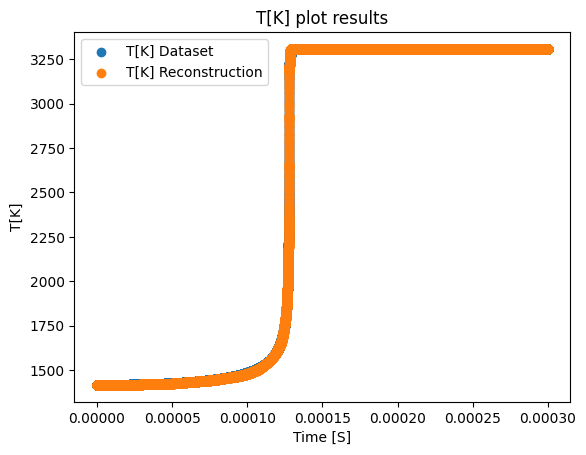

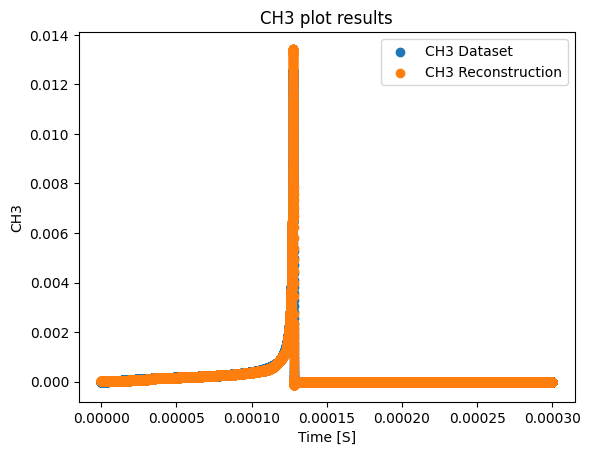

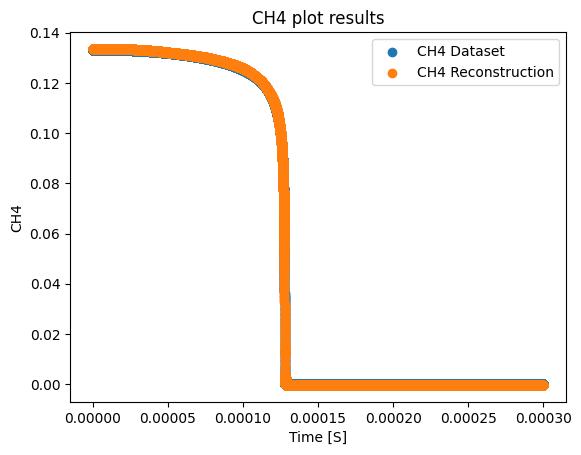

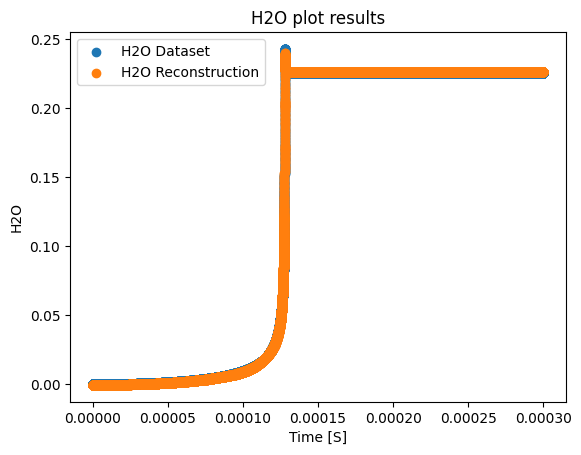

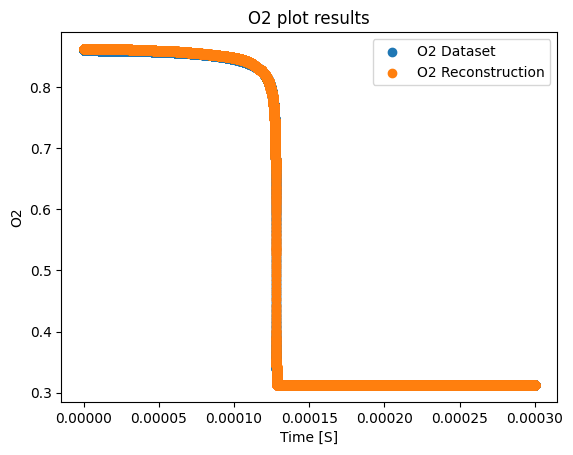

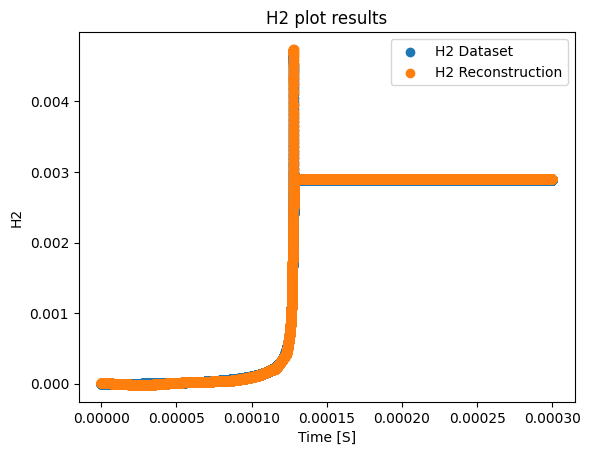

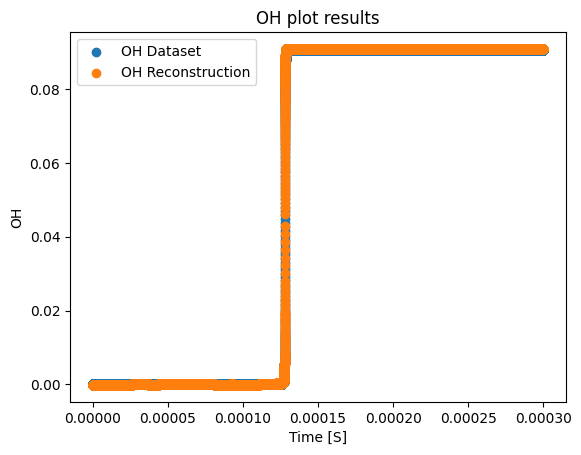

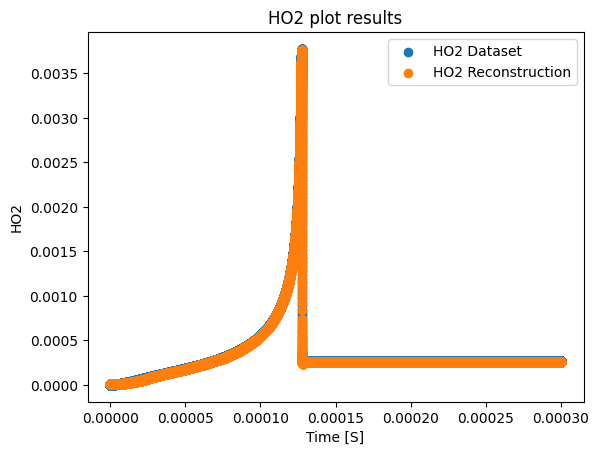

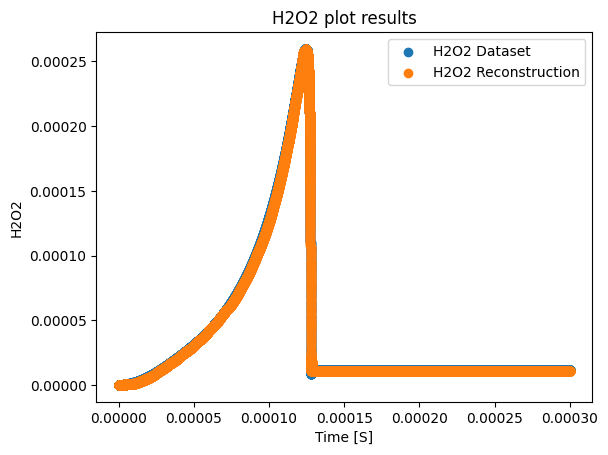

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

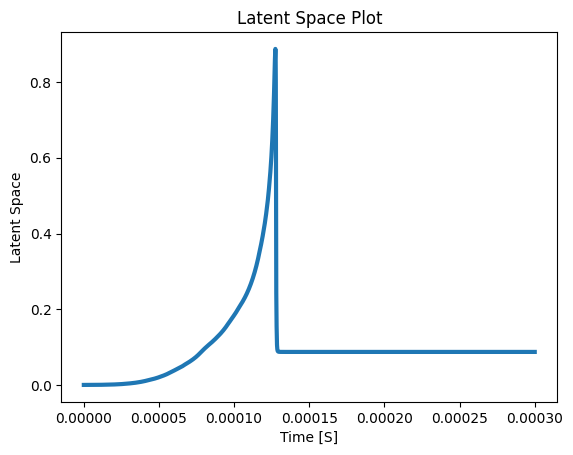

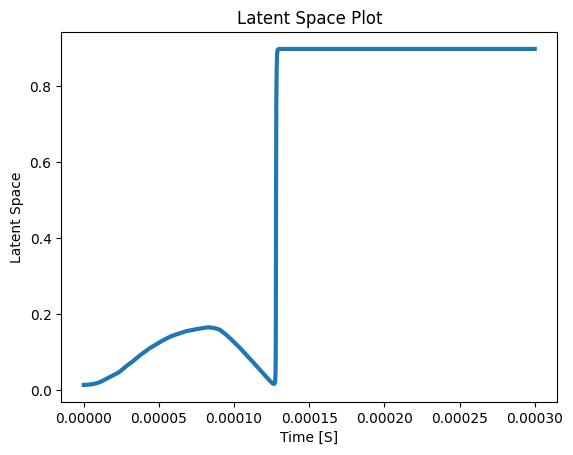

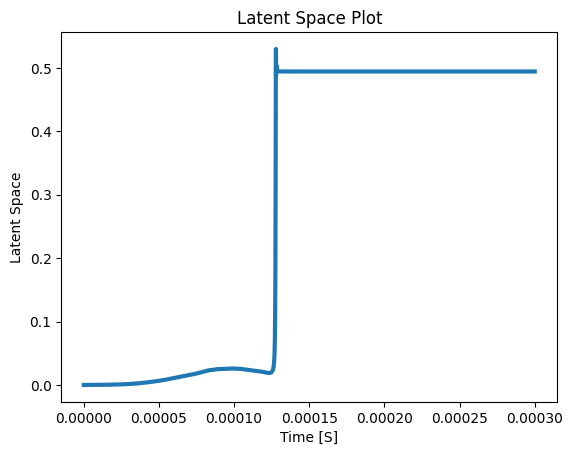

In [11]:
reduced_size=3

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [12]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.405009,1.042881e-11,8.353616e-10,2.607153e-11,0.956759,1.459889e-11,1.431770e-13,8.863142e-07,6.588270e-10,5.380474e-36,...,4.190559e-10,2.200316e-29,1.447609e-17,1.012118e-18,9.714320e-09,6.942646e-06,-5.449433e-04,1.071975e-28,8.147250e-29,4.230178e-30
1,0.405009,4.062645e-11,1.604340e-09,1.000191e-10,0.956759,5.673373e-11,1.055671e-12,1.772861e-06,2.633485e-09,2.362406e-34,...,1.612990e-09,3.639861e-28,5.808560e-17,6.301182e-18,1.953841e-08,7.023604e-06,-5.450415e-04,3.064422e-27,2.044251e-27,1.240434e-28
2,0.405009,8.906323e-11,2.312391e-09,2.159000e-10,0.956759,1.240263e-10,3.429429e-12,2.659651e-06,5.923432e-09,1.842594e-33,...,3.494488e-09,1.920113e-27,1.311714e-16,1.864556e-17,2.947984e-08,7.109492e-06,-5.451426e-04,2.172955e-26,1.401526e-26,9.017864e-28
3,0.405009,1.542864e-10,2.964697e-09,3.682110e-10,0.956759,2.141668e-10,7.914860e-12,3.546693e-06,1.052772e-08,1.597463e-32,...,5.983634e-09,6.016944e-27,2.341017e-16,4.008675e-17,3.954481e-08,7.199269e-06,-5.452462e-04,8.631405e-26,5.589639e-26,3.683638e-27
4,0.405009,2.349660e-10,3.565994e-09,5.520272e-10,0.956759,3.250014e-10,1.510252e-11,4.433995e-06,1.644542e-08,3.153527e-32,...,9.009605e-09,1.477154e-26,3.672580e-16,7.225469e-17,4.973822e-08,7.291998e-06,-5.453519e-04,2.496636e-25,1.634905e-25,1.093198e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,1.608241e-07,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119995,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,1.608241e-07,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119996,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,1.608241e-07,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26
119997,0.944816,1.923899e-01,3.345916e-01,9.837496e-01,0.348594,9.035184e-01,6.523008e-01,6.978837e-02,4.377263e-02,1.608241e-07,...,-3.787878e-24,-3.361816e-26,1.076127e-26,-1.599324e-30,-1.804854e-31,-1.089619e-33,-9.015124e-36,5.804199e-24,1.520262e-25,-4.089081e-26


In [13]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [14]:
corr_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.305081,0.386160,0.383657,0.380888,-0.310665,0.311775,0.316789,0.672638,0.367011,0.319071,...,0.102710,0.122339,0.115982,0.116509,0.106872,0.102918,0.028172,0.120060,0.116290,0.118017
1,0.688170,0.629371,0.631898,0.628799,-0.695801,0.698327,0.687921,0.141139,-0.296636,0.681461,...,-0.530207,-0.536546,-0.540902,-0.541119,-0.534136,-0.549999,0.078616,-0.535973,-0.538118,-0.539751
2,0.722249,0.798785,0.799057,0.793895,-0.730060,0.732710,0.735234,0.179689,-0.126032,0.722957,...,-0.376271,-0.371102,-0.377474,-0.376957,-0.376617,-0.388173,0.030519,-0.373372,-0.377153,-0.375445


HO2    0.672638
HCO    0.552378
CO     0.388260
H2     0.386160
CH     0.385453
Name: 0, dtype: float64
OH      0.698327
CO2     0.693265
T[K]    0.688170
H2O     0.687921
C       0.681461
Name: 1, dtype: float64
CO     0.800050
H      0.799057
H2     0.798785
O      0.793895
H2O    0.735234
Name: 2, dtype: float64


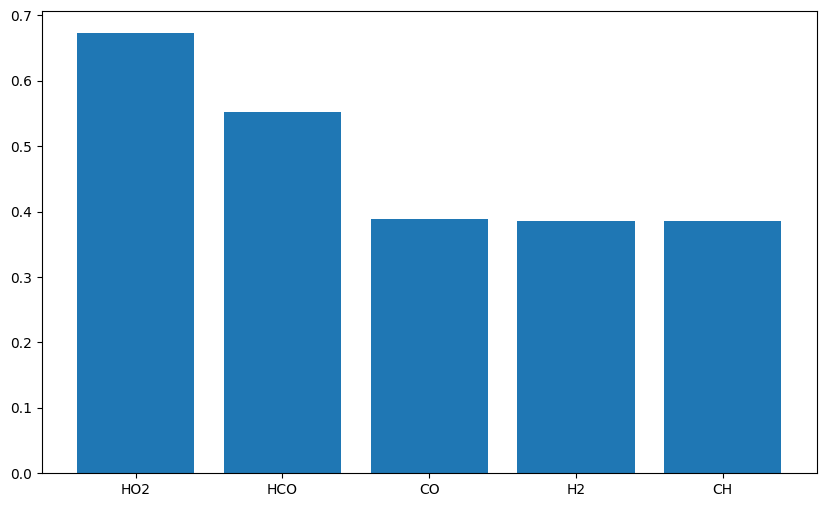

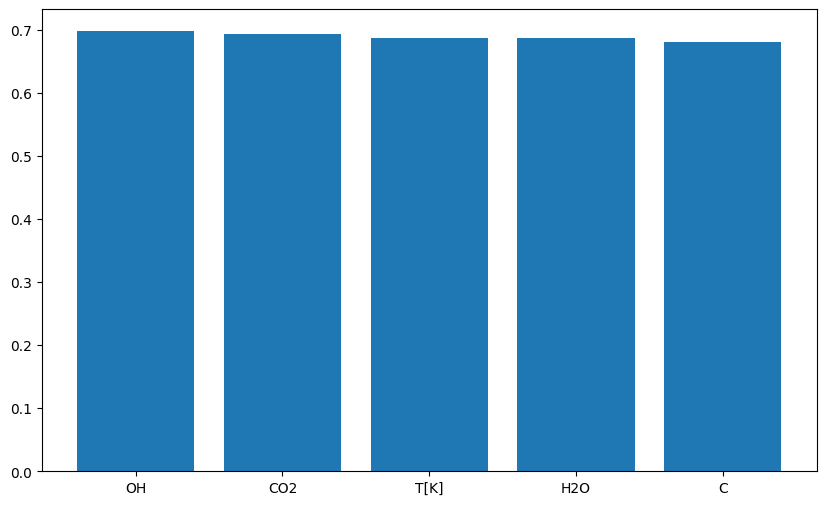

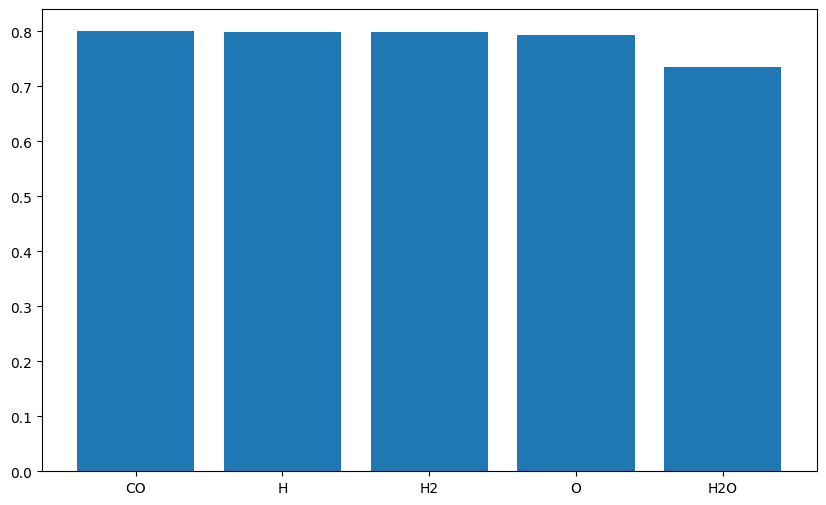

In [15]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [16]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [17]:
spearman_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.395787,0.454723,0.451492,0.450582,-0.396214,0.396451,0.402491,0.775955,0.435363,0.408214,...,0.070704,0.100908,0.088666,0.089286,0.076226,0.084279,0.008213,0.097975,0.090961,0.092438
1,0.859974,0.808229,0.810897,0.810533,-0.860734,0.861275,0.855240,0.178534,-0.351681,0.846333,...,-0.778935,-0.788150,-0.793405,-0.793604,-0.784092,-0.793101,0.123696,-0.787965,-0.790743,-0.791921
2,0.852163,0.904119,0.904323,0.903009,-0.852861,0.853398,0.857626,0.269355,-0.242993,0.850117,...,-0.699593,-0.687136,-0.701541,-0.700928,-0.700274,-0.702641,0.019611,-0.690362,-0.698703,-0.697208


HO2    0.775955
HCO    0.666084
CH     0.487949
CO     0.458217
H2     0.454723
Name: 0, dtype: float64
OH      0.861275
CO2     0.860292
T[K]    0.859974
H2O     0.855240
C       0.846333
Name: 1, dtype: float64
CO     0.907816
H      0.904323
H2     0.904119
O      0.903009
H2O    0.857626
Name: 2, dtype: float64


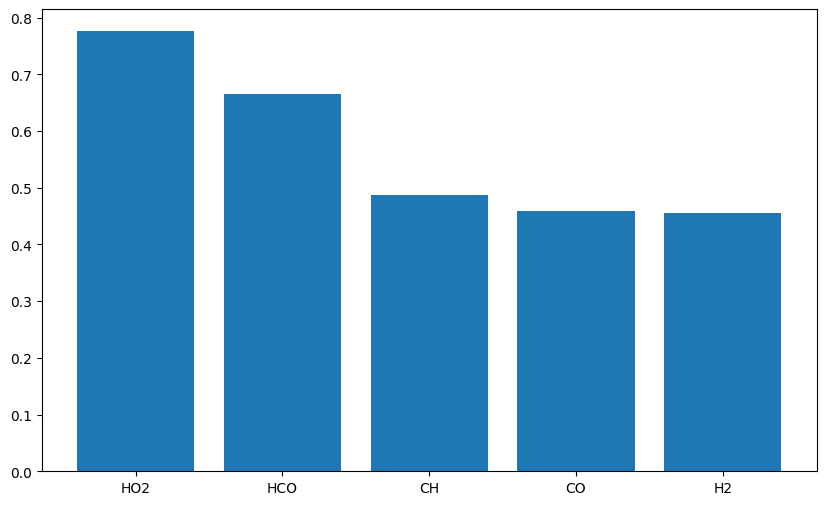

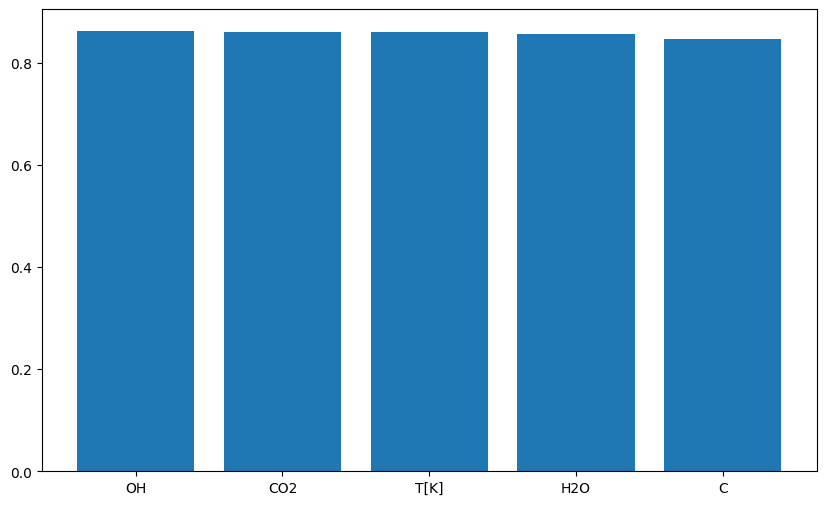

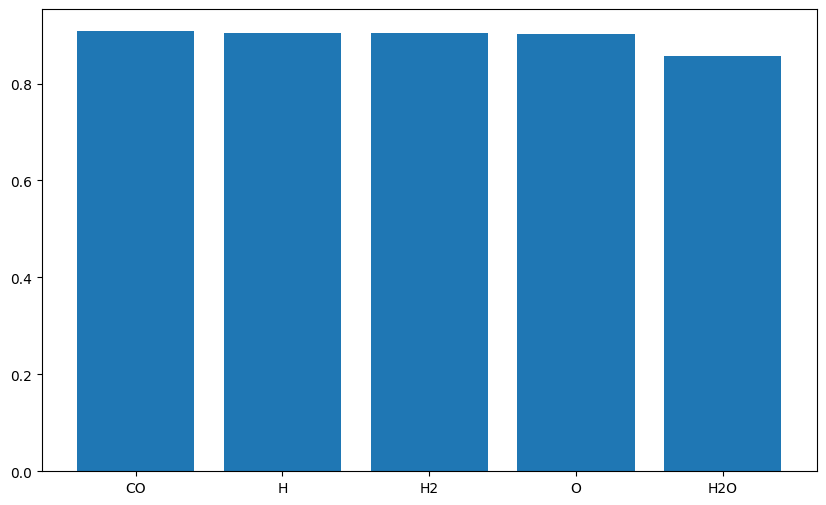

In [18]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [19]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [20]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(119998, 61)
(119998, 3)


In [21]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [22]:
corr_indexes_

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.305082,0.386192,0.383689,0.380922,-0.310664,0.311780,0.316787,0.672588,0.366986,0.319070,...,0.102700,0.122318,0.115975,0.116498,0.106863,0.102907,0.028146,0.120045,0.116275,0.118001
1,0.688172,0.629349,0.631876,0.628776,-0.695801,0.698327,0.687922,0.141132,-0.296654,0.681461,...,-0.530190,-0.536572,-0.540918,-0.541134,-0.534120,-0.549992,0.078603,-0.535998,-0.538141,-0.539772
2,0.722253,0.798765,0.799082,0.793920,-0.730062,0.732712,0.735236,0.179638,-0.126066,0.722914,...,-0.376239,-0.371126,-0.377488,-0.376971,-0.376585,-0.388141,0.030539,-0.373395,-0.377175,-0.375465


HO2    0.672588
HCO    0.552382
CO     0.388294
H2     0.386192
CH     0.385453
Name: 0, dtype: float64
OH      0.698327
CO2     0.693266
T[K]    0.688172
H2O     0.687922
C       0.681461
Name: 1, dtype: float64
CO     0.800029
H      0.799082
H2     0.798765
O      0.793920
H2O    0.735236
Name: 2, dtype: float64


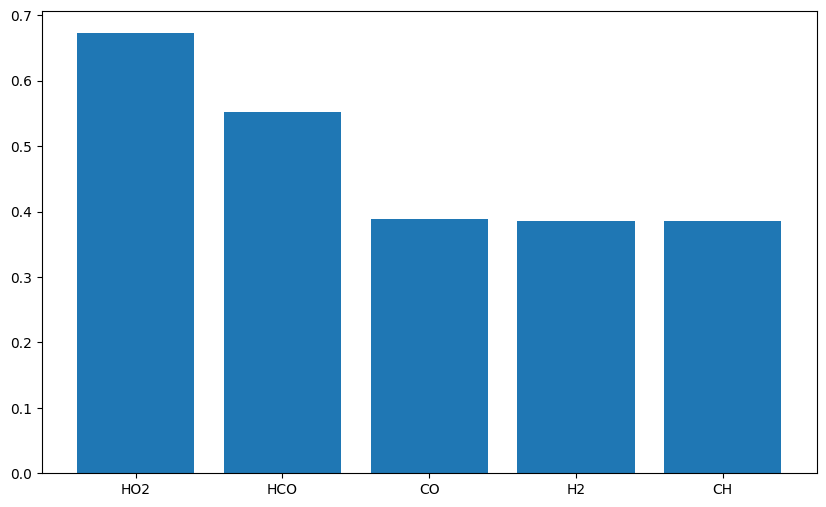

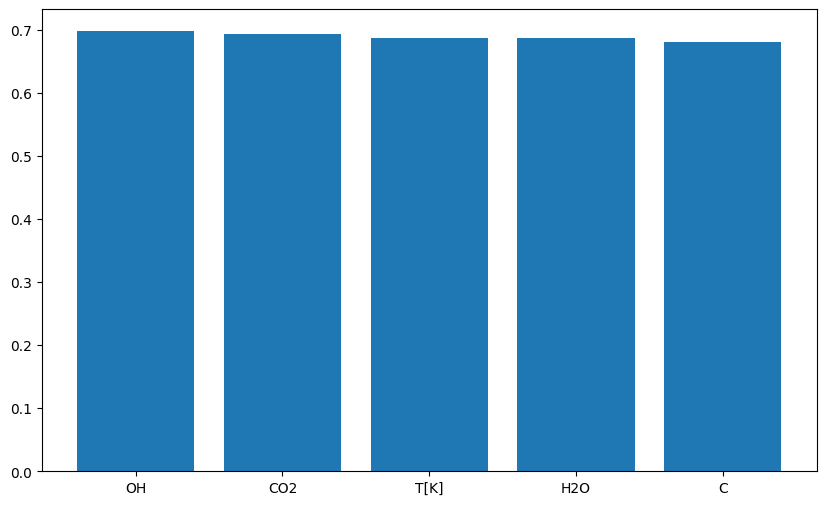

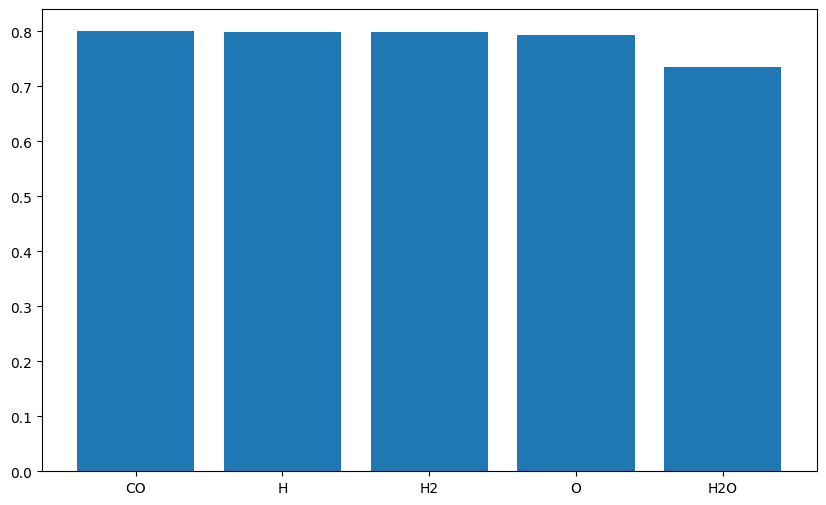

In [23]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)